# Chapter 8: Tree-Based Methods

## 3. Classification Error Rate, Gini Index, and Entropy

Consider the Gini index, classification error, and entropy in a simple classification setting with two classes. Create a single plot that displays each of these quantities as a function of p̂m1
. The x
-axis should display p̂m1
, ranging from 0 to 1, and the y
-axis should display the value of the Gini index, classification error, and entropy.

Hint: In a setting with two classes, p̂m1=1−p̂m2
. You could make this plot by hand, but it will be much easier to make in R.

Some code in this notebook is adapted from the following source: https://rpubs.com/lmorgan95/ISLR_CH8_Solutions

In [137]:
if(!require('Rmpfr')){
    install.packages('Rmpfr')
    library('Rmpfr')
}
if(!require('dplyr')){
    install.packages('dplyr')
    library('dplyr')
}
if(!require('tidyr')){
    install.packages('tidyr')
    library('tidyr')
}
if(!require('ggplot2')){
    install.packages('ggplot2')
    library('ggplot2')
}
if(!require('ISLR')){
    install.packages('ISLR')
    library('ISLR')
}
if(!require('tree')){
    install.packages('tree')
    library('tree')
}
if(!require('randomForest')){
    install.packages('randomForest')
    library('randomForest')
}
if(!require('gbm')){
    install.packages('gbm')
    library('gbm')
}
if(!require('caret')){
    install.packages('caret')
    library('caret')
}

Loading required package: caret

Loading required package: lattice



In [4]:
#class ratios
ratio_1 = seq(0,1,0.01)
ratio_2 = 1 - ratio_1

In [5]:
#E classification error rate
E = 1 - pmax(ratio_1,ratio_2) #pmax function returns the parallel maxima and minima for each element in two vectors. 

#Gini index
Gini = ratio_1 * (1 - ratio_1) + ratio_2 * (1 - ratio_2)

#Entropy 
D = -ratio_1 * log(ratio_1) + -ratio_2 * log(ratio_2) 

Warning message:
“Removed 2 row(s) containing missing values (geom_path).”


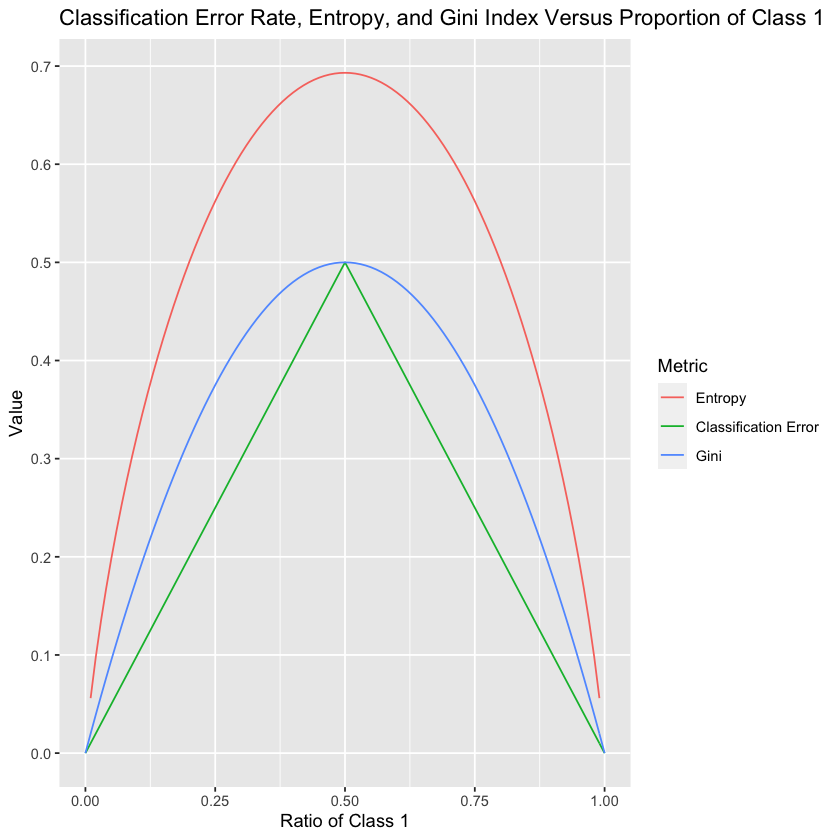

In [6]:
data.frame(ratio_1,ratio_2,E,Gini,D) %>% 
pivot_longer(cols = c(E,Gini,D), names_to="metric") %>%
ggplot(aes(x = ratio_1, y = value, col = factor(metric))) +
geom_line() +
scale_y_continuous(breaks = seq(0,1,0.1), minor_breaks = NULL) +
scale_color_hue(labels = c("Entropy", "Classification Error", "Gini")) + 
labs(col = "Metric", y = "Value", x = "Ratio of Class 1") +
ggtitle("Classification Error Rate, Entropy, and Gini Index Versus Proportion of Class 1")


## 5. Bagged Probabilities to Class Predictions

Suppose we produce ten bootstrapped samples from a data set containing red and green classes. We then apply a classification tree to each bootstrapped sample and, for a specific value of X
, produce 10
 estimates of P(Class is Red|X)
:

0.1,0.15,0.2,0.2,0.55,0.6,0.6,0.65,0.7, and 0.75.

There are two common ways to combine these results together into a single class prediction. One is the majority vote approach discussed in this chapter. The second approach is to classify based on the average probability. In this example, what is the final classification under each of these two approaches?

In [7]:
#create vector of probabilities 
P = c(0.1,0.15,0.2,0.2,0.55,0.6,0.6,0.65,0.7,0.75)

### Majority Vote Technique

In [8]:
class = ifelse(sum(P >= 0.5) > sum(P < 0.5), "Red", "Green")

In [9]:
class

[1] "Red"

### Average Technique

In [10]:
class = ifelse(mean(P)>= 0.5,"Red","Green")

In [11]:
class

[1] "Green"

## 8. APPLIED: Regression Trees, Random Forests

In the lab, a classification tree was applied to the Carseats data set after converting Sales into a qualitative response variable. Now we will seek to predict Sales using regression trees and related approaches, treating the response as a quantitative variable.

In [12]:
data('Carseats')

In [13]:
head(Carseats)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>
1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
5,4.15,141,64,3,340,128,Bad,38,13,Yes,No
6,10.81,124,113,13,501,72,Bad,78,16,No,Yes


### (a) `train`/`test` Split

In [14]:
set.seed(123, sample.kind='Rounding')

Warning message in set.seed(123, sample.kind = "Rounding"):
“non-uniform 'Rounding' sampler used”


In [15]:
#create 50:50 split

train_index = sample(1:nrow(Carseats), nrow(Carseats)/2)

trainDF = Carseats[train_index, ]
testDF = Carseats[-train_index, ]

In [16]:
nrow(trainDF)

[1] 200

In [17]:
nrow(testDF)

[1] 200

* 200 rows in both `train` and `test` sets.

### (b) Regression Tree Plot

Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

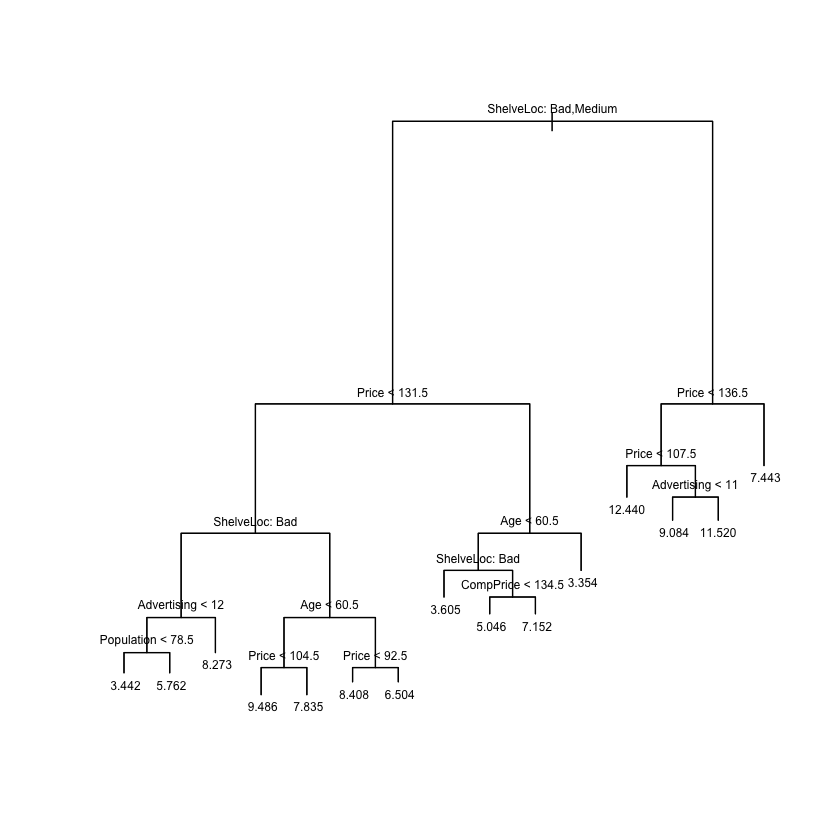

In [18]:
reg_tree = tree(Sales ~ ., data=trainDF)

plot(reg_tree)

#add text lables to tree plot
text(reg_tree,pretty=0, cex=0.6)

* We can tell which predictors are most important by the chronological order of the tree's splits. `ShelveLoc` and `Price` are most important as they're the first and second splits of the decision tree respectively. 

* This tree contains six internal nodes and eleven terminal nodes.

In [19]:
#this function takes as arguments predictions and actual values and returns the MSE
get_MSE = function(predictions,real){
    MSE = round(mean((predictions-real) ^2),2)
return(MSE)
}

In [20]:
reg_tree_preds = predict(reg_tree, testDF)

get_MSE(reg_tree_preds,testDF$Sales)

[1] 4.43

### (c) Cross-Validation Pruning

Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

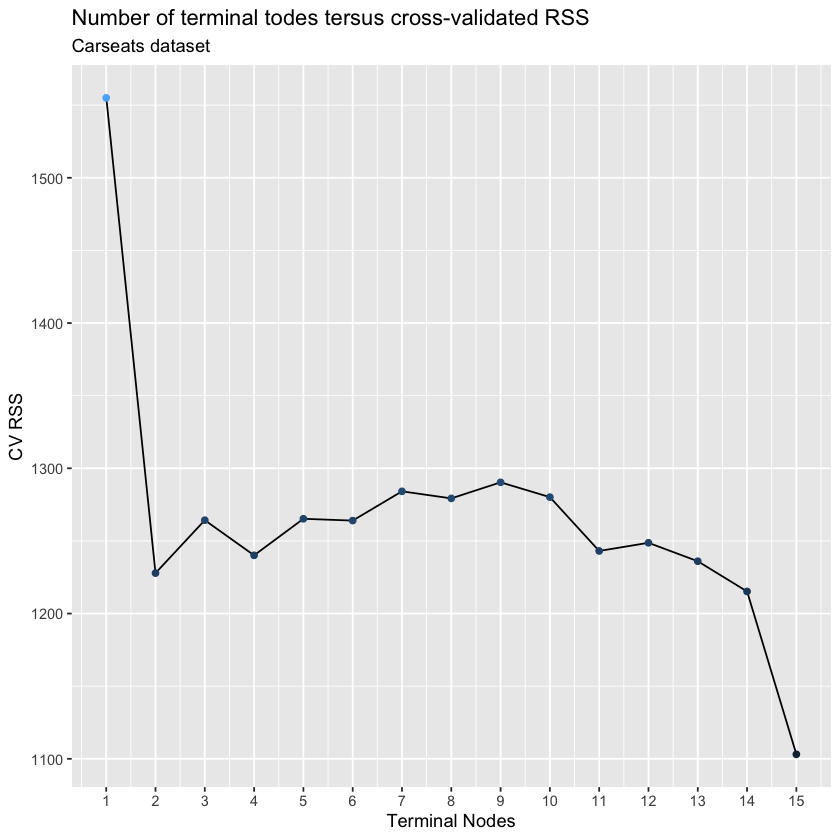

In [21]:
set.seed(123)

#5 fold cross validation
reg_tree_cv = cv.tree(reg_tree,K=5)

#create dataframe to store tree size and error
data.frame(terminal_nodes=reg_tree_cv$size,RSS_CV = reg_tree_cv$dev) %>%
    ggplot(aes(x=terminal_nodes,y=RSS_CV)) + geom_line() + 
    geom_point(aes(color=RSS_CV)) + 
    scale_x_continuous(breaks=seq(1,15,1)) +
    theme(legend.position = "none") +
    labs(title = "Number of terminal todes tersus cross-validated RSS",
       subtitle = "Carseats dataset",
       x = "Terminal Nodes",
       y = "CV RSS")
    
    


 * The tree with the lowest cross-validated RSS is the full tree without any pruned branches.

In [22]:
reg_tree_pruned = prune.tree(reg_tree, best=15)

reg_tree_pruned_preds = predict(reg_tree_pruned,testDF)

get_MSE(reg_tree_pruned_preds,testDF$Sales)

[1] 4.43

* We see no difference in MSE, which make sense as we did not actually prune any branches.

### (d) Bagged Trees

Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the importance() function to determine which variables are most important.



In [23]:
set.seed(123)

#seeting the arg mtry to the number of predictors in the model will result in bootstrapped sampling at each split where all predictors are candidates

tree_bag = randomForest(y = trainDF$Sales,
                       x= trainDF[,-1], #exclude DV var
                       mtry=length(trainDF[,-1]),
                       importance=TRUE,
                       keep.forest=TRUE)

In [24]:
#predict 

tree_bag_preds = predict(tree_bag,testDF)
get_MSE(tree_bag_preds,testDF$Sales)

[1] 2.54

In [25]:
importance(tree_bag) %>%
as.data.frame() %>% arrange(desc(IncNodePurity))

,%IncMSE,IncNodePurity
,<dbl>,<dbl>
ShelveLoc,55.7407043,449.434429
Price,49.9977701,418.505042
Age,22.6078130,183.789989
CompPrice,19.8284712,133.610654
Advertising,17.0633784,108.997142
Population,1.4145224,76.898651
Income,3.0078444,65.894173
Education,2.6182821,43.211778
Urban,-0.9148386,9.488943


`ShelveLoc`, `Price`, and `Age` are the most important predictors.

### (e) Random Forests

Use random forests to analyze this data. What test MSE do you obtain? Use the importance() function to determine which variables are most important. Describe the effect of m
, the number of variables considered at each split, on the error rate obtained.

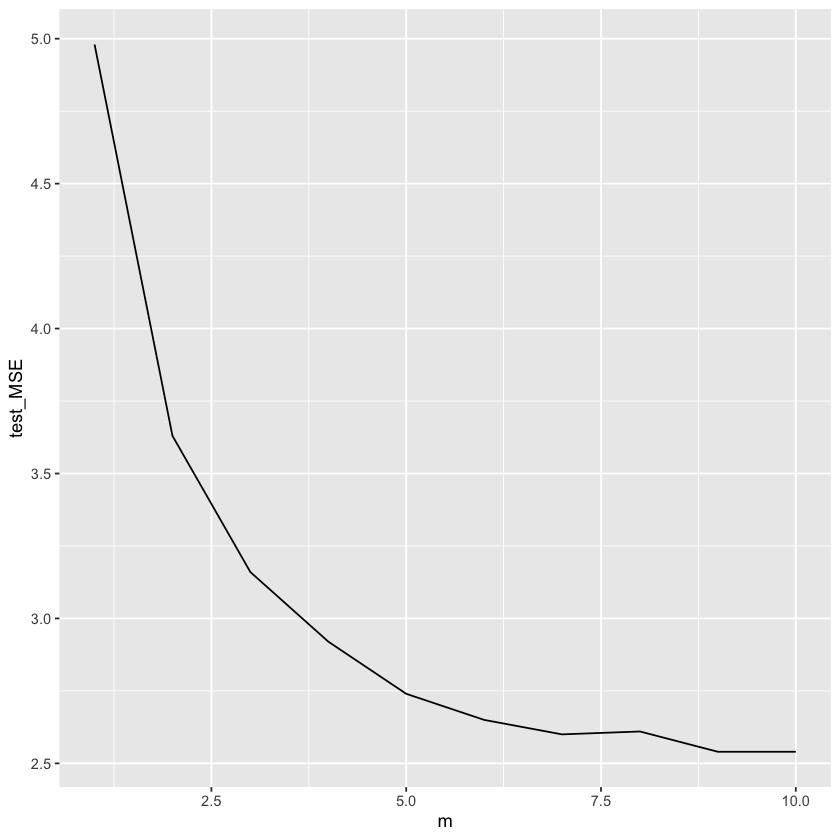

In [26]:
MSE <- c()

i <- 1


for (m in 1:10) {
  set.seed(1)
  
  rf <- randomForest(y = trainDF$Sales, 
                          x = trainDF[ ,-1], 
                          mtry = m, 
                          importance = T)
  
  test_pred <- predict(rf, testDF)
  
  MSE[i] <- get_MSE(test_pred,testDF$Sales)
  
  i <- i + 1

}

data.frame(m=1:10, test_MSE=MSE) %>%
ggplot(aes(x=m,y=test_MSE)) + geom_line()

In [27]:
importance(rf)

,%IncMSE,IncNodePurity
CompPrice,16.4217624,133.034620
Income,1.4586825,64.756291
Advertising,15.5436185,110.376820
Population,1.5539927,77.703431
Price,46.5323768,430.475226
ShelveLoc,58.0255727,450.067653
Age,21.8923976,179.156833
Education,2.0073370,45.000394
Urban,-0.3789805,10.221340
US,3.7468923,6.904687


## 9. Applied The `OJ` dataset (Classification Trees)

This problem involves the OJ data set which is part of the ISLR package.

In [28]:
data('OJ')

In [29]:
head(OJ)

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
2,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
3,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
4,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
5,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0
6,CH,230,7,1.69,1.99,0.00,0.0,0,1,0.965228,1.99,1.69,0.30,Yes,0.000000,0.000000,0.30,0


In [30]:
glimpse(OJ)

Registered S3 method overwritten by 'cli':
  method     from
  print.tree tree



Rows: 1,070
Columns: 18
$ Purchase       <fct> CH, CH, CH, MM, CH, CH, CH, CH, CH, CH, CH, CH, CH, CH,…
$ WeekofPurchase <dbl> 237, 239, 245, 227, 228, 230, 232, 234, 235, 238, 240, …
$ StoreID        <dbl> 1, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 2, 2…
$ PriceCH        <dbl> 1.75, 1.75, 1.86, 1.69, 1.69, 1.69, 1.69, 1.75, 1.75, 1…
$ PriceMM        <dbl> 1.99, 1.99, 2.09, 1.69, 1.69, 1.99, 1.99, 1.99, 1.99, 1…
$ DiscCH         <dbl> 0.00, 0.00, 0.17, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0…
$ DiscMM         <dbl> 0.00, 0.30, 0.00, 0.00, 0.00, 0.00, 0.40, 0.40, 0.40, 0…
$ SpecialCH      <dbl> 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ SpecialMM      <dbl> 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0…
$ LoyalCH        <dbl> 0.500000, 0.600000, 0.680000, 0.400000, 0.956535, 0.965…
$ SalePriceMM    <dbl> 1.99, 1.69, 2.09, 1.69, 1.69, 1.99, 1.59, 1.59, 1.59, 1…
$ SalePriceCH    <dbl> 1.75, 1.75, 1.69, 1.69, 1.69, 1.69, 1.69, 1.75, 1.75, 1…
$ PriceDiff     

### (a) `train`/`test` Split

Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.

In [71]:
set.seed(123)

#create index for train set
train_ind = sample(1:nrow(OJ),800)

trainDF = OJ[train_ind,]
testDF = OJ[-train_ind,]

In [70]:
print(nrow(trainDF))
print(nrow(testDF))

[1] 800
[1] 270


### (b) Classification Tree

Fit a tree to the training data, with Purchase as the response and the other variables as predictors. Use the summary() function to produce summary statistics about the tree, and describe the results obtained. What is the training error rate? How many terminal nodes does the tree have?

In [72]:
dec_tree = tree(Purchase ~ .,data=trainDF)

summary(dec_tree)



Classification tree:
tree(formula = Purchase ~ ., data = trainDF)
Variables actually used in tree construction:
[1] "LoyalCH"   "PriceDiff" "SpecialCH" "PctDiscMM"
Number of terminal nodes:  10 
Residual mean deviance:  0.7289 = 575.8 / 790 
Misclassification error rate: 0.1612 = 129 / 800 

* The tree has seven leaf nodes with a `missclassification error rate` of `0.1612`. Four predictors were used in branch splits. They are: `LoyalCH`, `PriceDiff`, `SpecialCH`, and `PctDiscMM`.

### (c) `tree()` - Text Interpretation 

Type in the name of the tree object in order to get a detailed text output. Pick one of the terminal nodes, and interpret the information displayed.

In [53]:
#dec_tree

* this causes a runtime error.

### (d) Plotting

Create a plot of the tree, and interpret the results.

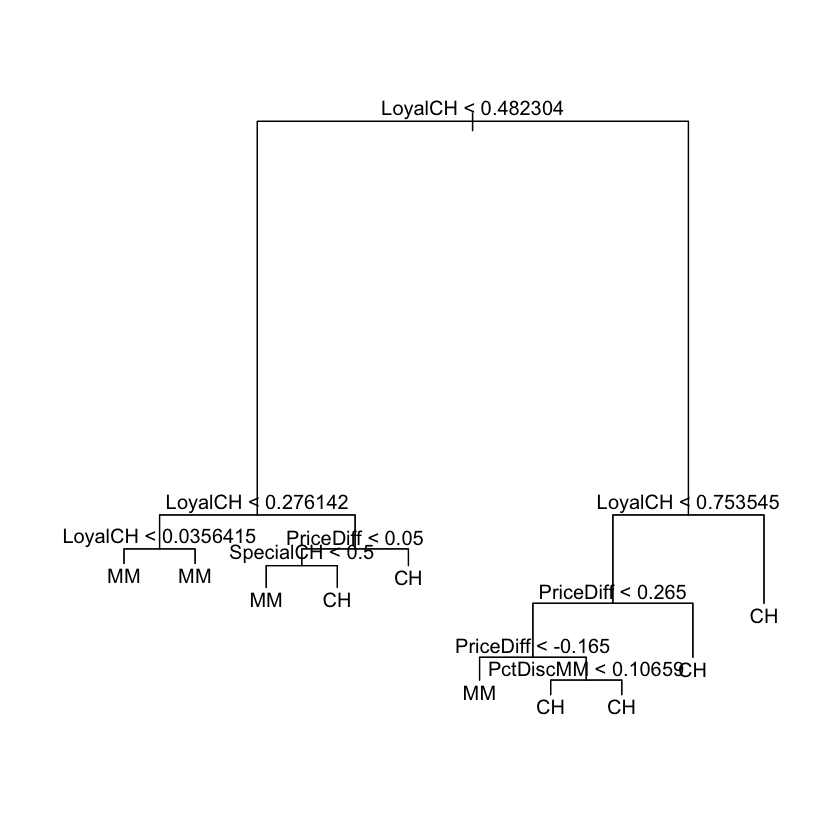

In [73]:
plot(dec_tree)
text(dec_tree)

* `LoyalCH` is clearly the most important predictor in terms of information gain. The classification tree's first three internal nodes or splits are based on this predictor. 

We can manually impose some of the sequential decisions made at a given terminal node and check node purity. We'll do so for the terminal node corresponding to `LoyalCH < 0.0356415`.

In [74]:
trainDF %>% 
filter(LoyalCH < 0.482304, #root node
      LoyalCH < 0.276142,
      LoyalCH < 0.0356415) %>%
select(Purchase) %>% table()

.
CH MM 
 1 55 

* This leaf node is highly pure with `55/56` observations belonging to the `MM` class. 

### (e) Test Error

Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?

In [76]:
test_dec_tree_preds = predict(dec_tree,testDF, type='class')

#compute confusion matrix
table(test_dec_tree_preds, test_actual = testDF$Purchase)

                   test_actual
test_dec_tree_preds  CH  MM
                 CH 158  37
                 MM  11  64

* The accuracy of this classification tree is `82%`

In [79]:
222/270

[1] 0.8222222

* The classification error rate of this classification tree is `0.18`

In [78]:
1 - mean(test_dec_tree_preds == testDF$Purchase)

[1] 0.1777778

### (f) Cost-Complexity Pruning

Apply the cv.tree() function to the training set in order to determine the optimal tree size.

Specifying `FUN = prune.misclass` indicates that the purpose of the cross-validation is to find the optimal tree depth with respect to classification error. The default takes into consideration `deviance`.

In [82]:
set.seed(123)

class_tree_cv = cv.tree(dec_tree, K = 5, FUN = prune.misclass)
class_tree_cv

$size
[1] 10  8  5  2  1

$dev
[1] 157 155 156 163 316

$k
[1] -Inf    0    2    6  163

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

* We can see that a tree of size `8` is optimal.

### (g) CV Error Plot

Produce a plot with tree size on the x
-axis and cross-validated classification error rate on the y
-axis.

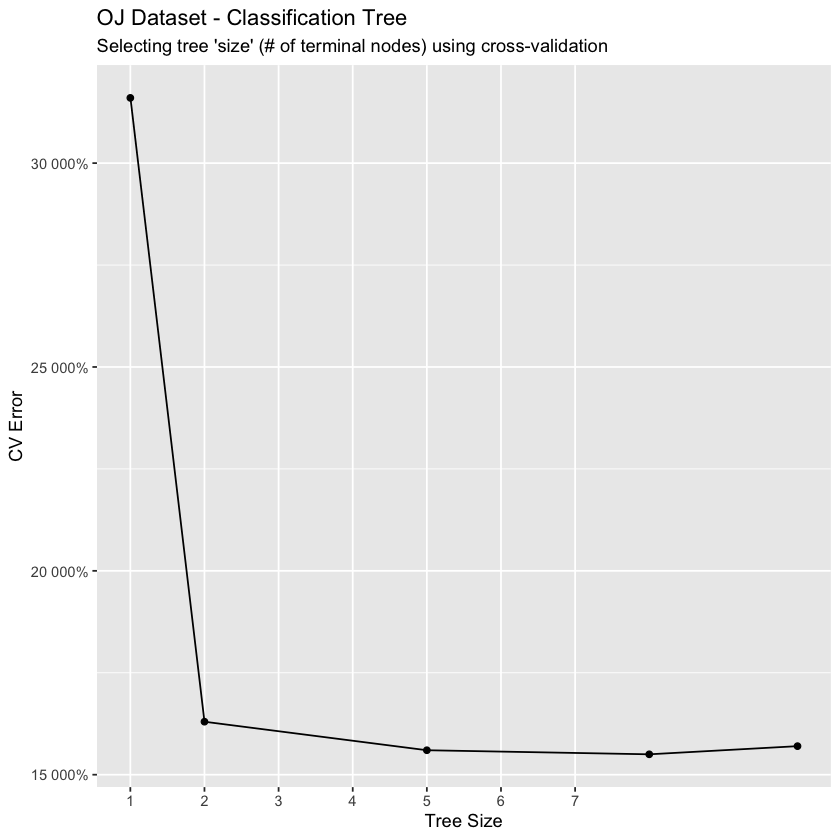

In [92]:
data.frame(tree_size = class_tree_cv$size, cv_error=class_tree_cv$dev) %>% 
ggplot(aes(x=tree_size,y=cv_error)) + geom_line() + geom_point() +
scale_x_continuous(breaks = seq(1, 7), minor_breaks = NULL) +
scale_y_continuous(labels = scales::percent_format()) +
  scale_color_manual(values = c("deepskyblue3", "green")) +
  theme(legend.position = "none") +
  labs(title = "OJ Dataset - Classification Tree",
       subtitle = "Selecting tree 'size' (# of terminal nodes) using cross-validation",
       x = "Tree Size",
        y = "CV Error")


### (h) Best Tree - CV Error

Which tree size corresponds to the lowest cross-validated classification error rate?

* As visible in section `(g)`'s plot, the tree size corresponding to the least `CV Error` is `8 terminal nodes`.

### (i) Best Tree - Selecting

Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.

In [94]:
class_tree_pruned <- prune.tree(dec_tree, best = 8)
#class_tree_pruned # this throws error

### (j) Training Error Comparison

Compare the training error rates between the pruned and unpruned trees. Which is higher?

In [96]:
mean(predict(dec_tree, type = "class") != trainDF$Purchase)

[1] 0.16125

In [97]:
mean(predict(class_tree_pruned, type = "class") != trainDF$Purchase)

[1] 0.16125

* pruned tree and unpruned tree perform exactly the same in this instance.

### (k) Test Error Comparison

Compare the test error rates between the pruned and unpruned trees. Which is higher?

In [98]:
mean(predict(dec_tree, type = "class", newdata = testDF) != testDF$Purchase)

[1] 0.1777778

In [99]:
mean(predict(class_tree_pruned, type = "class", newdata = testDF) != testDF$Purchase)

[1] 0.1777778

## 10. APPLIED: The Hitters Dataset (Boosting)

We now use boosting to predict Salary in the Hitters data set.

In [101]:
data('Hitters')

In [102]:
glimpse(Hitters)

Rows: 322
Columns: 20
$ AtBat     <int> 293, 315, 479, 496, 321, 594, 185, 298, 323, 401, 574, 202, …
$ Hits      <int> 66, 81, 130, 141, 87, 169, 37, 73, 81, 92, 159, 53, 113, 60,…
$ HmRun     <int> 1, 7, 18, 20, 10, 4, 1, 0, 6, 17, 21, 4, 13, 0, 7, 3, 20, 2,…
$ Runs      <int> 30, 24, 66, 65, 39, 74, 23, 24, 26, 49, 107, 31, 48, 30, 29,…
$ RBI       <int> 29, 38, 72, 78, 42, 51, 8, 24, 32, 66, 75, 26, 61, 11, 27, 1…
$ Walks     <int> 14, 39, 76, 37, 30, 35, 21, 7, 8, 65, 59, 27, 47, 22, 30, 11…
$ Years     <int> 1, 14, 3, 11, 2, 11, 2, 3, 2, 13, 10, 9, 4, 6, 13, 3, 15, 5,…
$ CAtBat    <int> 293, 3449, 1624, 5628, 396, 4408, 214, 509, 341, 5206, 4631,…
$ CHits     <int> 66, 835, 457, 1575, 101, 1133, 42, 108, 86, 1332, 1300, 467,…
$ CHmRun    <int> 1, 69, 63, 225, 12, 19, 1, 0, 6, 253, 90, 15, 41, 4, 36, 3, …
$ CRuns     <int> 30, 321, 224, 828, 48, 501, 30, 41, 32, 784, 702, 192, 205, …
$ CRBI      <int> 29, 414, 266, 838, 46, 336, 9, 37, 34, 890, 504, 186, 204, 1…
$ CWalks    <int> 

In [103]:
head(Hitters)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<dbl>,<fct>
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NA,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


###  (a) `Salary` - Remove Missings & Log-Transform

Remove the observations for whom the salary information is unknown, and then log-transform the salaries.

In [104]:
# checking missing values for Salary

sum(is.na(Hitters$Salary))

[1] 59

There are `59` rows with missing values for `Salary`.

In [105]:
# select only non-null rows
Hitters_noNA = Hitters[!is.na(Hitters$Salary),]

#log transform salary
Hitters_noNA$Salary_log = log(Hitters_noNA$Salary)

Distribution of Salary Prior to Normalization

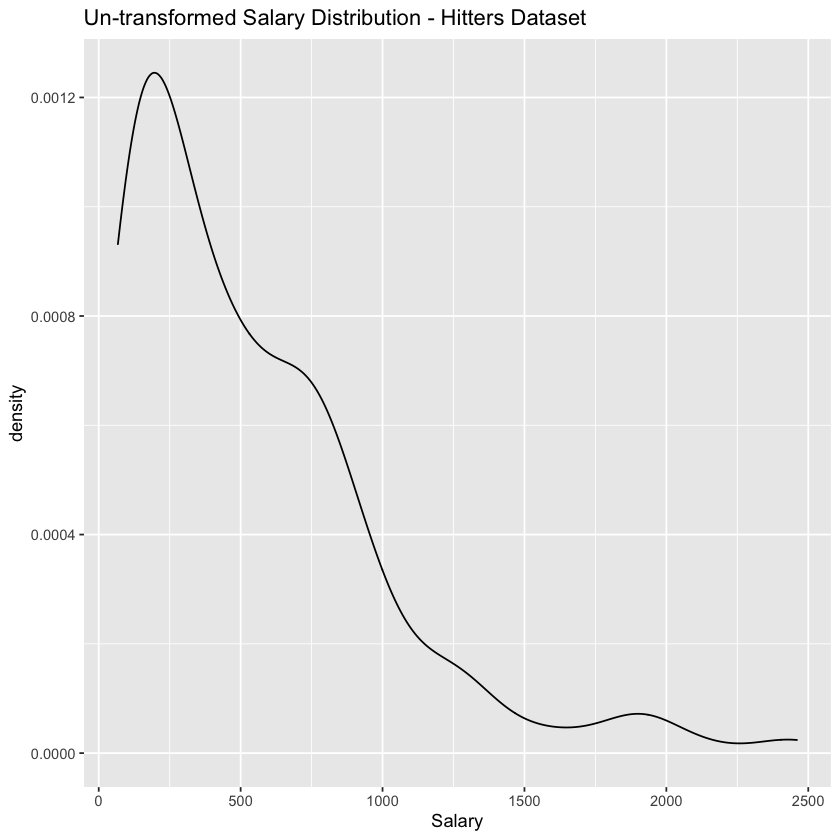

In [113]:
ggplot(Hitters_noNA,aes(x=Salary)) + geom_density() +
ggtitle("Un-transformed Salary Distribution - Hitters Dataset")

Normalized Salary Distribution

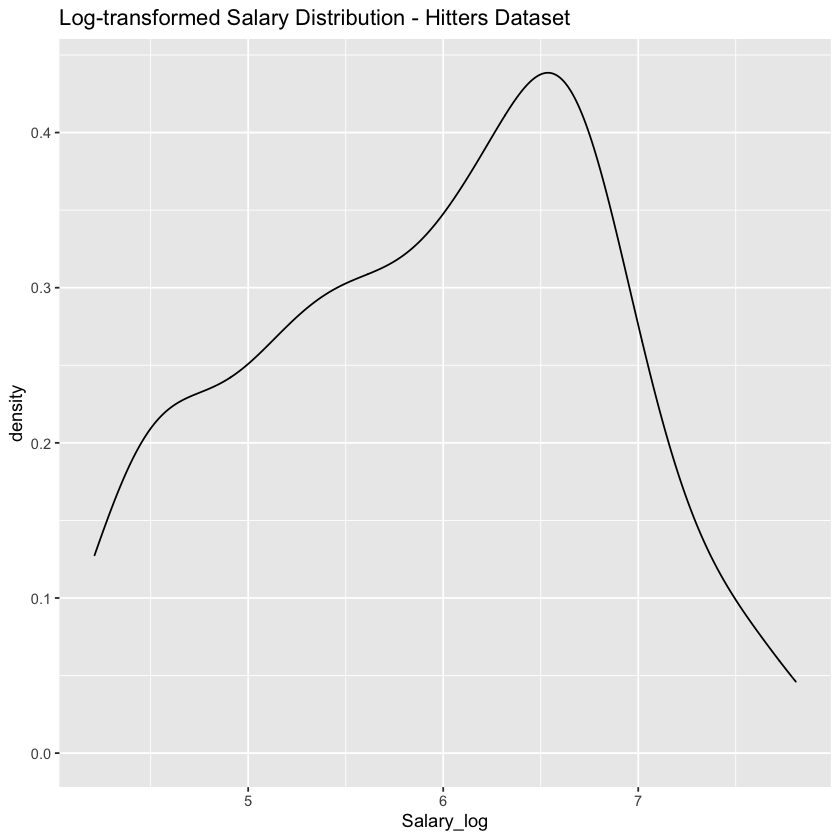

In [114]:
ggplot(Hitters_noNA,aes(x=Salary_log)) + geom_density() +
ggtitle("Log-transformed Salary Distribution - Hitters Dataset")

* Log-transforming the `Salary` creates a more Gaussian distribution.

### (b) train/test Split

Create a training set consisting of the first 200 observations, and a test set consisting of the remaining observations

In [126]:
train_ind = sample(1:200,)

trainDF = Hitters_noNA[train_ind,]
testDF = Hitters_noNA[-train_ind,]

In [127]:
print(nrow(trainDF))
print(nrow(testDF))

[1] 200
[1] 63


### (c) Boosting - Varying Shrinkage (train MSE)

Perform boosting on the training set with 1,000 trees for a range of values of the shrinkage parameter λ
. Produce a plot with different shrinkage values on the x
-axis and the corresponding training set MSE on the y
-axis.

Warning message:
“Removed 61 rows containing missing values (geom_point).”
Warning message:
“Removed 61 row(s) containing missing values (geom_path).”


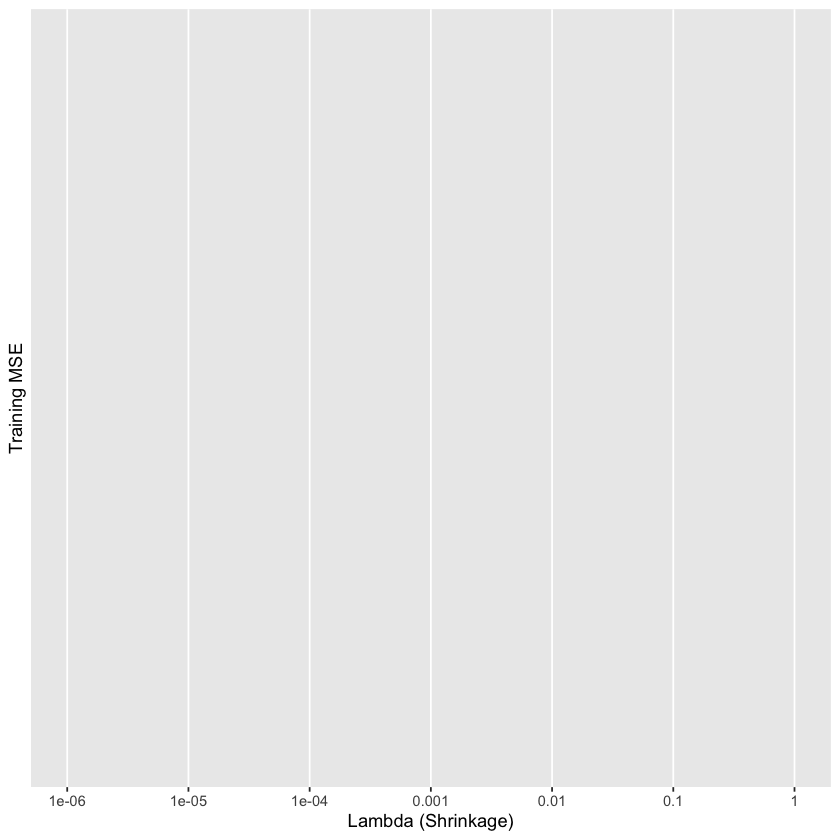

In [129]:
lambda_seq <- 10^seq(-6, 0, 0.1)

set.seed(1)

train_MSE <- c()
test_MSE <- c()

for (i in 1:length(lambda_seq)) {
  boost_TEMP <- gbm(trainDF$Salary_log ~ . - trainDF$Salary, 
                    data = trainDF, 
                    distribution = "gaussian", 
                    n.trees = 1000, 
                    interaction.depth = 2, 
                    shrinkage = lambda_seq[i])
  
  train_MSE[i] <- mean((predict(boost_TEMP, trainDF, n.trees = 1000) - trainDF$log_Salary)^2)
  
  test_MSE[i] <- mean((predict(boost_TEMP, testDF, n.trees = 1000) - testDF$log_Salary)^2)
}

data.frame(lambda = lambda_seq, train_MSE) %>%
  ggplot(aes(x = lambda, y = train_MSE)) + 
  geom_point(size = 2, col = "deepskyblue3") + 
  geom_line(col = "grey55") + 
  scale_x_continuous(trans = 'log10', breaks = 10^seq(-6, 0), labels = 10^seq(-6, 0), minor_breaks = NULL) + 
  labs(x = "Lambda (Shrinkage)", 
       y = "Training MSE")


### (d) Boosting - Varying Shrinkage (test MSE)

Produce a plot with different shrinkage values on the x-axis and the corresponding test set MSE on the y-axis.

Warning message:
“Removed 61 rows containing missing values (geom_point).”
Warning message:
“Removed 61 row(s) containing missing values (geom_path).”


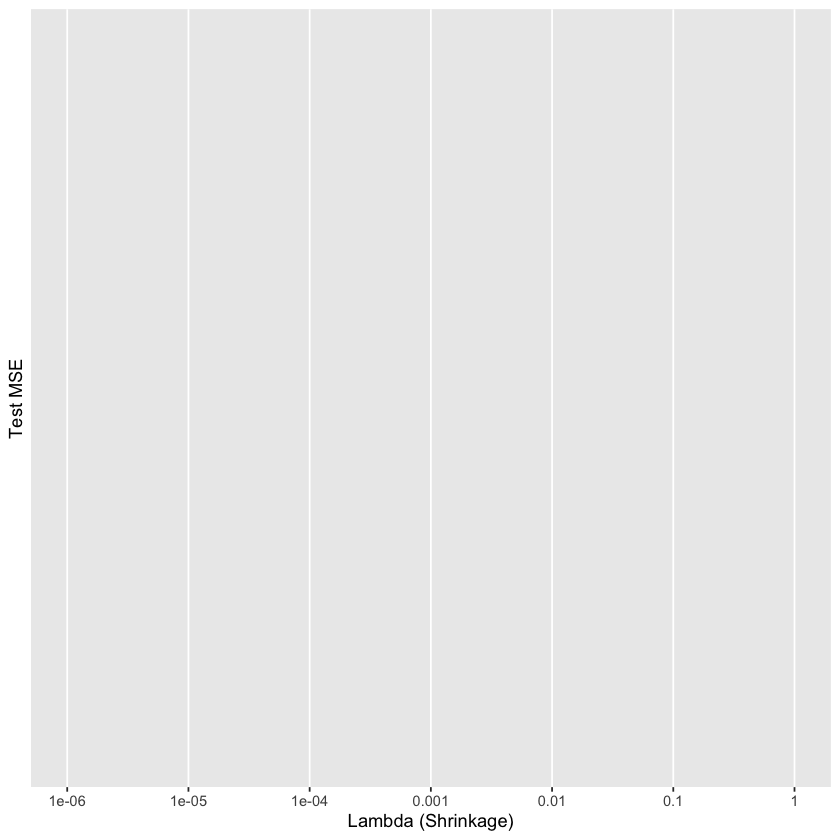

In [130]:
data.frame(lambda = lambda_seq, test_MSE) %>%
  ggplot(aes(x = lambda, y = test_MSE)) + 
  geom_point(size = 2, col = "deepskyblue3") + 
  geom_line(col = "grey55") + 
  scale_x_continuous(trans = 'log10', breaks = 10^seq(-6, 0), labels = 10^seq(-6, 0), minor_breaks = NULL) + 
  labs(x = "Lambda (Shrinkage)", 
       y = "Test MSE")

### (e) Boosting vs PLS vs Lasso

Compare the test MSE of boosting to the test MSE that results from applying two of the regression approaches seen in Chapters 3 and 6

#### Boosting 

In [141]:
set.seed(1)

ctrl <- trainControl(method = "repeatedcv", number = 5, repeats = 3, verboseIter = F)

gbm_grid <- expand.grid(n.trees = 1000, interaction.depth = 2, n.minobsinnode = 10, shrinkage = 10^seq(-6, 0, 0.1))

model_gbm <- train(Salary_log ~ . - Salary, 
                   data = trainDF, 
                   method = "gbm",
                   distribution = "gaussian", 
                   verbose = F,
                   metric = "MSE",
                   maximize = F,
                   trControl = ctrl, 
                   tuneGrid = gbm_grid)


Warning message in (function (kind = NULL, normal.kind = NULL, sample.kind = NULL) :
“non-uniform 'Rounding' sampler used”
Warning message in train.default(x, y, weights = w, ...):
“The metric "MSE" was not in the result set. RMSE will be used instead.”


In [142]:
# return best lambda value
model_gbm$bestTune$shrinkage %>% round(4) # 

[1] 0.0079

In [145]:
# return test error rate
gbm_test <- mean((predict(model_gbm, testDF) - testDF$Salary_log)^2) %>% round(4) # 0.2816
gbm_test

[1] 0.2803

### Lasso

Benchmark the `boosted` tree to `the Lasso`

In [147]:
ctrl <- trainControl(method = "repeatedcv", number = 5, repeats = 10, verboseIter = F)
set.seed(1)

model_lasso <- train(Salary_log ~ . - Salary, 
                   data = trainDF, 
                   method = "glmnet", 
                   preProcess = c("center", "scale"), 
                     metric = "MSE",
                     maximize = F,
                     trControl = ctrl, 
                     tuneGrid = expand.grid(alpha = 1,
                     lambda = seq(0, 0.1, 0.001)))


Warning message in (function (kind = NULL, normal.kind = NULL, sample.kind = NULL) :
“non-uniform 'Rounding' sampler used”
Warning message in train.default(x, y, weights = w, ...):
“The metric "MSE" was not in the result set. RMSE will be used instead.”


In [148]:
#find optimal lambda
model_lasso$bestTune$lambda

[1] 0.004

In [150]:
# compute test error 
lasso_test <- mean((predict(model_lasso, testDF) - testDF$Salary_log)^2) 
lasso_test

[1] 0.4698852

`boosting` performs significantly better than `the Lasso regression`.

### (f) Variable Importance

Which variables appear to be the most important predictors in the boosted model?

$x
[1] "Predictor"

$title
[1] "Boosted Tree Predictor Importance - Hitters Dataset"

attr(,"class")
[1] "labels"

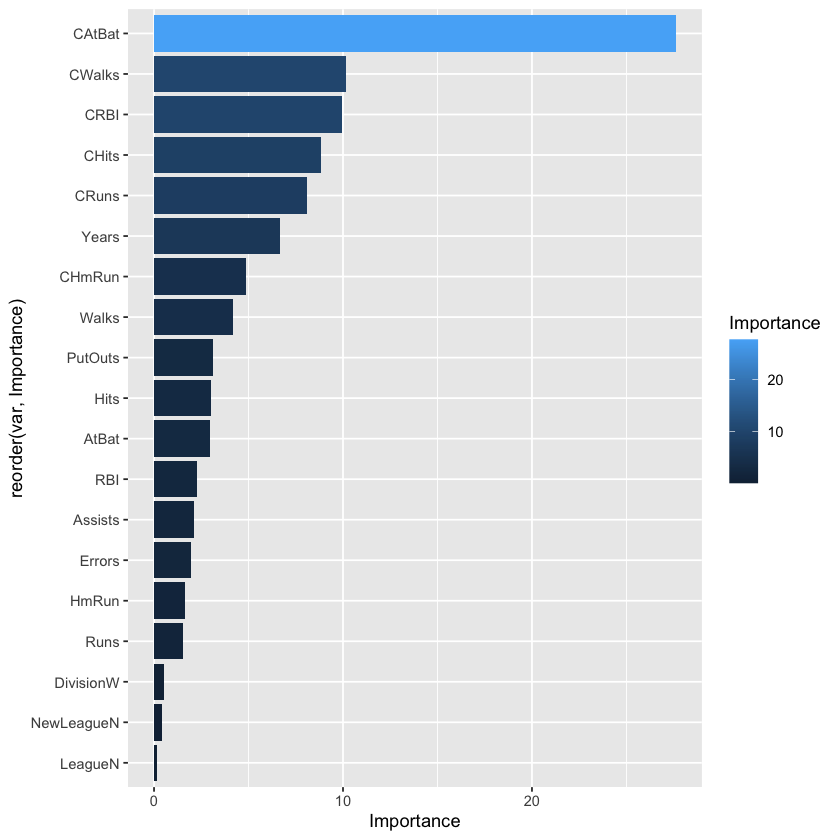

In [154]:
summary(model_gbm$finalModel, plotit = F) %>%
  rename("Importance" = "rel.inf") %>%
  ggplot(aes(x = reorder(var, Importance), y = Importance, fill = Importance)) +
  geom_bar(stat = "identity") + 
  coord_flip()
  labs(title = "Boosted Tree Predictor Importance - Hitters Dataset", 
       x = "Predictor")

### (g) Bagging

In [156]:
set.seed(123)

ctrl <- trainControl(method = "repeatedcv", number = 5, repeats = 3, verboseIter = F)

bagged_tree <- train(y = trainDF$Salary_log, 
                   x = trainDF, 
                   method = "rf",
                   metric = "MSE",
                   maximize = F,
                   trControl = ctrl, 
                   tuneGrid = expand.grid(mtry = 19))

Warning message in (function (kind = NULL, normal.kind = NULL, sample.kind = NULL) :
“non-uniform 'Rounding' sampler used”
Warning message in train.default(y = trainDF$Salary_log, x = trainDF, method = "rf", :
“The metric "MSE" was not in the result set. RMSE will be used instead.”


In [159]:
# find cv train RMSE
bagged_tree_cv <- bagged_tree$results$RMSE
bagged_tree_cv

[1] 0.03083776

In [161]:
# compute test error rate

bagged_tree_test_MSE <- mean((predict(bagged_tree, testDF) - testDF$Salary_log)^2)
bagged_tree_test_MSE

[1] 0.0001492142